Histograms and required functions

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import iqr
from numpy import histogram2d
from numpy import histogram
from sklearn.metrics import mutual_info_score
from matplotlib import pyplot as plt 
from scipy.stats import entropy
from scipy.stats import wasserstein_distance

# Define mutual information function
def minfo(x, y):
    # Compute mutual information between x and y
    bins_x = math.ceil(2*len(x)**(1/2)) # Rice rule
    bins_y = math.ceil(2*len(y)**(1/2))
    c_xy = histogram2d(np.squeeze(x),np.squeeze(y), [bins_x,bins_y])[0]
    #c_xy = histogram2d(np.squeeze(x),np.squeeze(y), bins=15)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def Generate_2dhist(x,y):
    bins_x = math.ceil(2*len(x)**(1/2)) # Rice rule
    bins_y = math.ceil(2*len(y)**(1/2))
    H, yedges, xedges = histogram2d(np.squeeze(x),np.squeeze(y), [bins_x,bins_y])
    return H, yedges, xedges

def Generate_1dhist(x):
    hist,bins=histogram(x,bins=math.ceil(2*len(x)**(1/2)),density=True) #rice rule
    return hist,bins

def Compute_entropy(x):
    data = histogram(x,bins=math.ceil(2*len(x)**(1/2)),density=True)[0]
    H = entropy(data)
    return H

def Compute_Wdistance(x,y):
    x=Generate_1dhist(x)[0]
    y=Generate_1dhist(y)[0]
    return wasserstein_distance(x,y)

Data processing

In [2]:
df = pd.read_csv("scsecdata/GeneExp_Data_Blastula.csv")
df=df.T

#Add labes to columns and rows correctly
df.rename(columns=df.iloc[0], inplace = True)
df = df.drop(labels="GeneID", axis=0)
#erase comulns with duplicated labels
df = df.loc[:,~df.columns.duplicated()].copy()
#normalise the cell's space for each Gene 
df = df.div(df.sum(axis=1), axis=0)
#remove rows of cells full or zeros
df=df.loc[~df.apply(lambda row: (row==0).all(), axis=1)]
#remove Genes starting with code "MT"
df = df.loc[:,~df.columns.str.startswith('MT')].copy()
#remove rows (Cells) with less than 5-10% counts (2k numbers) bigger than zero
df=df.loc[~df.apply(lambda row: 1-(row==0).sum()/len(row)<0.1, axis=1)]
#remove columns (Genes) with less than 5% counts bigger than zero (3 numbers bigger than zero)
df=df.loc[:,~df.apply(lambda column: 1-(column==0).sum()/len(column)<0.05, axis=0)].copy()

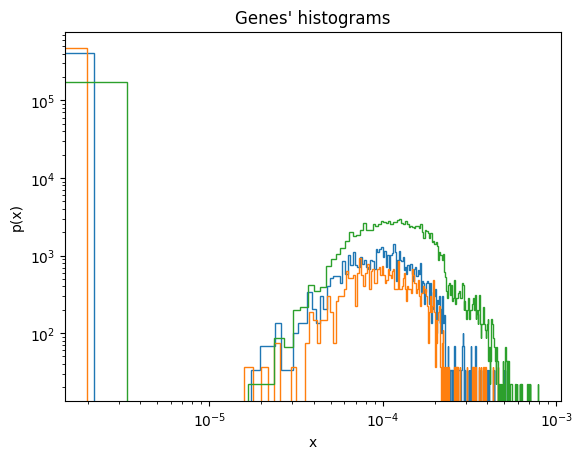

In [21]:
#x=df.iloc[:,[10]]
import math
hist1,bins1=Generate_1dhist(df.iloc[:,[0]])
hist2,bins2=Generate_1dhist(df.iloc[:,[3]])
hist3,bins3=Generate_1dhist(df.iloc[:,[10]])
plt.stairs(hist1, bins1)
plt.stairs(hist2, bins2)
plt.stairs(hist3, bins3)
plt.title("Genes' histograms")
plt.ylabel("p(x)")
plt.xlabel("x")
plt.yscale('log')
plt.xscale('log')
plt.show()

In [5]:
d1=wasserstein_distance(hist1,hist3)
print(d1)

1286.9796535525509


In [11]:
mi = minfo(df.iloc[:,[3]],df.iloc[:,[10]])
print(mi)

0.11811935380291819


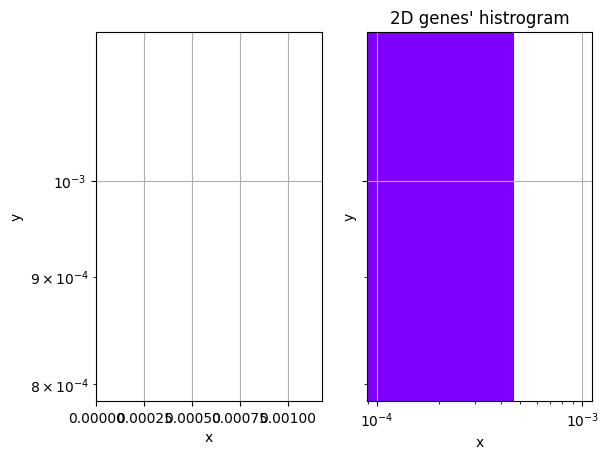

In [25]:
x = df.iloc[:,[1]]
y = df.iloc[:,[10]]
z = df.iloc[:,[3]]
# Compute 2d histogram. Note the order of x/y and xedges/yedges
H, yedges, xedges = Generate_2dhist(y, x)
H2, yedges2, xedges2 = Generate_2dhist(x, z)
# Plot histogram using pcolormesh
fig, (ax1, ax2)= plt.subplots(ncols=2, sharey=True)
plt.title("2D genes' histrogram")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax1.pcolormesh(xedges, yedges, H, cmap='rainbow')
ax2.pcolormesh(xedges2, yedges2, H2, cmap='rainbow')


#ax1.plot(x, 2*np.log(x), 'k-')
#ax1.set_xlim(x.min(), x.max())
#ax1.set_ylim(y.min(), y.max())
ax1.set_xlabel('x')
ax1.set_ylabel('y')
#ax2.set_xlim(x.min(), x.max())
#ax2.set_ylim(y.min(), y.max())
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax1.grid()
ax2.grid()
plt.show()

In [20]:
mi = minfo(x,y)
print(mi)
mi = minfo(y,x)
print(mi)

0.2608505653626548
0.2608505653626548


In [31]:
df.shape

(13624, 10704)

In [10]:
# Build MI matrix
import random
num_features = 100
num_columns = len(df.columns)
MI_matrix = np.zeros((num_features,num_features))
MI_distances = np.zeros((num_features,num_features))
Hk= {}

for col_i in range(0,num_features):
    Hk.update({df.columns[col_i]:{"Entropy":Compute_entropy(df.iloc[:,col_i]),
                                  "Histogram":Generate_1dhist(df.iloc[:,col_i])}})
    for col_j in range(col_i,num_features):
        MI_matrix[col_i,col_j] = minfo(df.iloc[:,col_i],df.iloc[:,col_j])
        MI_distances[col_i,col_j] = Compute_Wdistance(df.iloc[:,col_i],df.iloc[:,col_j])

MI_matrix= MI_matrix+MI_matrix.T-np.diag(np.diag(MI_matrix))
MI_distances= MI_distances+MI_distances.T-np.diag(np.diag(MI_distances))
MI_df = pd.DataFrame(MI_matrix,columns =  df.columns[0:num_features], index =  df.columns[0:num_features])


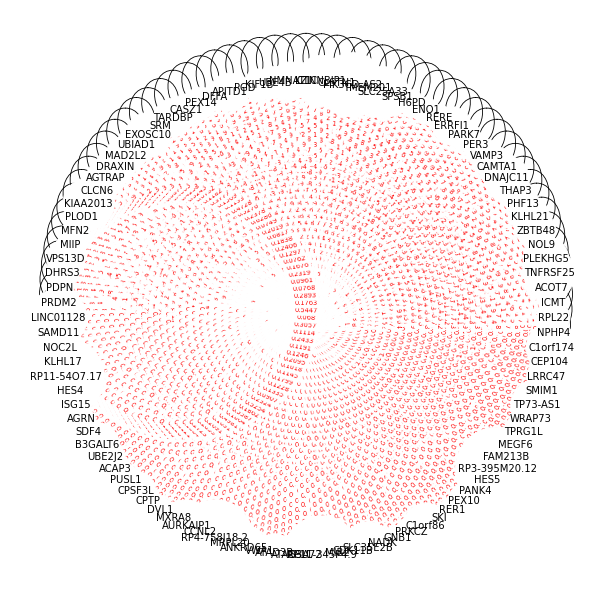

In [11]:
import networkx as nx
from pyvis.network import Network

G = nx.Graph()
G.add_nodes_from(df.columns[0:num_features])
for col_i in range(0,num_features):
    for col_j in range(col_i,num_features):
        if MI_matrix[col_i,col_j]>0.008:
            G.add_edge(df.columns[col_i],df.columns[col_j], weight = MI_matrix[col_i,col_j])

#nx.set_node_attributes(G, Hk)
labelList=df.columns[0:num_features].tolist()
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.1]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.1]
pos = nx.shell_layout(G) # positions for all nodes
#nx.draw(G,pos,h_labels=True, font_weight='bold')
edge_labels = dict([((n1, n2), round(d['weight'],4))
                    for n1, n2, d in G.edges(data=True)])

fig = plt.figure(1, figsize=(10, 10), dpi=60,frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
nx.draw_networkx_nodes(G, pos, 
                       node_size=[len(i)**2 * 60 for i in pos],
                       node_color ='w', 
                       node_shape="o") #['C{}'.format(i) for i in positions] for less than 10 nodes
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1, edge_color='k')
nx.draw_networkx_edges(G, pos, edgelist=esmall,width=1, edge_color='g', style='dashed') #, alpha=0.2
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                             font_color='red', font_size=8)
nx.draw_networkx_labels(G,pos)
plt.savefig('graph.png')

In [14]:
from pyvis.network import Network

net = Network()
net.from_nx(G)
net.toggle_physics(True)
net.show_buttons(filter_=['physics'])
net.save_graph("netgenes.html")

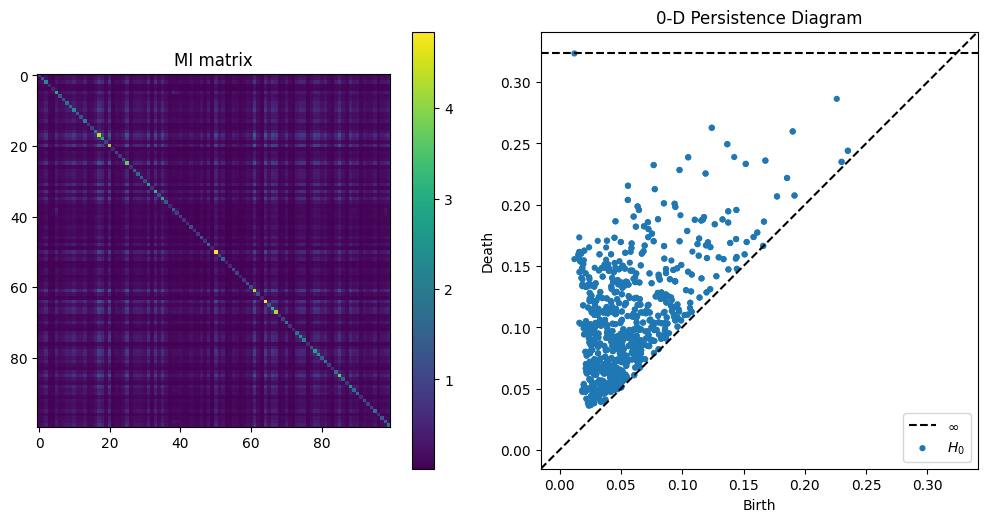

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import PIL

from persim import plot_diagrams
from ripser import ripser, lower_star_img

dgm = lower_star_img(MI_matrix)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(MI_matrix)
plt.colorbar()
plt.title("MI matrix")
plt.subplot(122)
plot_diagrams(dgm)
plt.title("0-D Persistence Diagram")
plt.tight_layout()
plt.show()



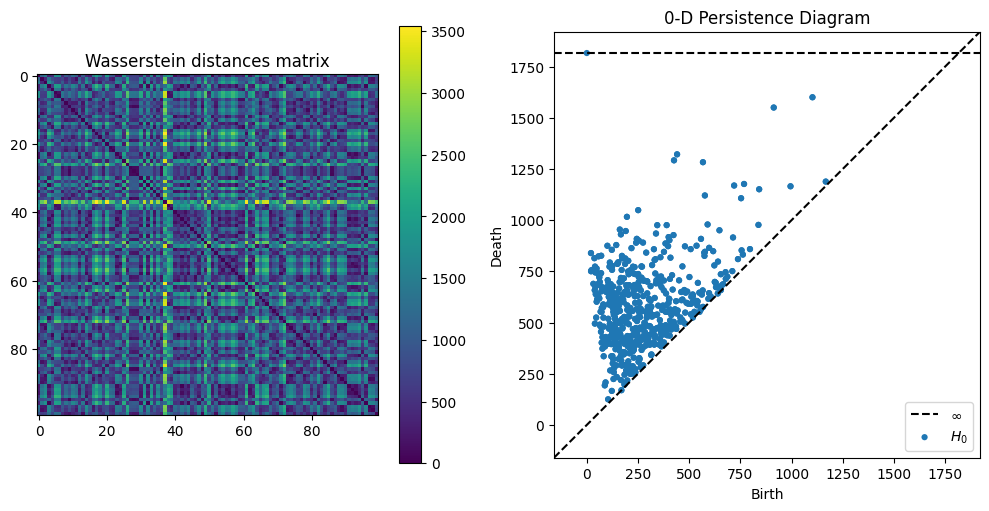

In [16]:
dgm = lower_star_img(MI_distances)
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(MI_distances)
plt.colorbar()
plt.title("Wasserstein distances matrix")
plt.subplot(122)
plot_diagrams(dgm)
plt.title("0-D Persistence Diagram")
plt.tight_layout()
plt.show()